#IWS Module 1:

This is a brief documentation for the module 1 using Recurrent Neural Network (RNN)

##Clarifications:
*   Module 1, as well as Module 2 & 3, were developed by the ISU team for 2019 IWS challenge. Under the time constraint, the purpose of the prototyped system with all three modules is to demonstrate the value of intelligent water systems to utilities and foster adoption of smart water technologies, and show how to leverage data using the tools to help utilities make better decisions.
*   All codes are provided as is without any guaranttee and liability responsibility from the developer side (i.e., the ISU team). 





Mount Google drive to Colab environment. The working directory should be matching the actual user's Google drive file system.

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/IWS/Delivery/")

Mounted at /content/drive


In [2]:
from pandas import read_csv
from pandas import datetime
from pandas import to_numeric
from pandas import concat
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

#tf.enable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from keras.layers import SimpleRNN, Dense, LSTM, Bidirectional, GRU
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

import os
import random as rn

import itertools
#from keras import backend as K

print(tf.__version__)

2.3.0


In [3]:
#Setting a seed for the pseudorandom number generator. 
#This allows us to reproduce the results from our script:
#fix the seed
n = 5
np.random.seed(100 * n)
rn.seed(10000 * n)

In [4]:
#Depending on the actual running environment, you may specify if using GPU, or only CPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Tensorflow session configuration.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1000 * n)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
series = read_csv('Kirie_Edited_Data.csv', header=0, parse_dates=[0], index_col=0,squeeze=True)
series = series.replace('^\s*$', np.nan, regex=True)
series = series.fillna(method='ffill')
series

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,TKN,PRCP_NOOA
Date,,,,,,,,,
2001-01-01,984.0,170.0,173,15.93,14.0,4.58,72,29.97,0.00
2001-01-02,924.0,122.0,174,15.52,14.4,4.52,72,29.96,0.00
2001-01-03,1135.0,300.0,303,14.19,21.9,6.06,72,36.11,0.00
2001-01-04,1013.0,192.0,228,15.43,19.4,5.33,72,34.83,0.00
2001-01-05,1088.0,226.0,210,14.77,19.3,5.41,72,34.06,0.00
...,...,...,...,...,...,...,...,...,...
2018-12-27,892.0,264.0,157,12.45,11.1,3.84,85,23.53,0.66
2018-12-28,776.0,104.0,94,10.61,6.2,1.97,85,16.76,0.08
2018-12-29,898.0,148.0,83,11.38,7.4,2.7,85,18.81,0.05


In [6]:
#narmalization
#lag defines how many historical data are used to predict a specific wasterwater characteristic (e.g., BOD5)
lag = 7

#num_features defines how many historical wasterwater characteristics are used. We have 9 in total (i.e., TS, BOD5, NH3, etc.)
num_features = 9

from pandas import DataFrame
from sklearn import preprocessing

names = series.columns

x = series.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

series_normalized = DataFrame(x_scaled, columns=names)
#The following line of code will do the same normalization as the code above.
#series_normalized = (series - np.min(series))/(np.max(series)-np.min(series))
series_normalized

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,TKN,PRCP_NOOA
0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
1,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000
2,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000
3,0.204749,0.056998,0.079395,0.454180,0.175248,0.143314,0.441441,0.242636,0.000000
4,0.226470,0.067764,0.072590,0.433746,0.174345,0.145640,0.441441,0.237209,0.000000
...,...,...,...,...,...,...,...,...,...
6569,0.169708,0.079797,0.052552,0.361920,0.100271,0.100000,0.558559,0.163002,0.096210
6570,0.136114,0.029132,0.028733,0.304954,0.056007,0.045640,0.558559,0.115292,0.011662
6571,0.171445,0.043065,0.024575,0.328793,0.066847,0.066860,0.558559,0.129739,0.007289
6572,0.165653,0.035465,0.031002,0.364706,0.057814,0.059593,0.558559,0.130514,0.000000


In [7]:
# table2lags() Shifts a dataFrame along its time axis (i.e., index) n steps 
# (moving down/up if step is a positive/negative number), determined by min_lag and max_lag, 
# and merge all shiffted dataframes into a single one and return, 
# without including the original DataFrame (the one shifted 0 step).
# "values" is a list, and each item in "values" is a shifted dataframe.
# Input: Table: a DataFrame; max_lag: the maximum shifting; min_lag: the minimum shifting; 
# In this module, no need to include the original dataframe or shift the dataframe up, and thus min_lag = 1 by default
# separator: used to concatenate the step value (e.g., 1, 2, 3) to the original column label. E.g., SO4_1, SO4_2, etc.
# Output: a dataframe
def table2lags(table, max_lag, min_lag=1, separator='_'):
    values = []
    for i in range(min_lag, max_lag + 1):
        #append shiffted dataframe into the list (i.e., values)
        values.append(table.shift(i).copy()) 
        #replace the last item or dataframe's columns by column_n; n is the shift step  
        values[-1].columns = [c + separator + str(i) for c in table.columns] 
    #pandas.concat is used to merge all dataframes (as items in values) into a single dataframe
    return concat(values, axis=1) 

#prepare all historical (e.g., one day ago, two day ago,...) data into one dataframe. 
#For all missing data, replaced by its closest future values

X = table2lags(series_normalized, lag)
X = X.fillna(method='bfill')
X

,Total Solids_1,SS_1,BOD5_1,NH3_1,Org-N_1,P-TOT_1,SO4_1,TKN_1,PRCP_NOOA_1,Total Solids_2,SS_2,BOD5_2,NH3_2,Org-N_2,P-TOT_2,SO4_2,TKN_2,PRCP_NOOA_2,Total Solids_3,SS_3,BOD5_3,NH3_3,Org-N_3,P-TOT_3,SO4_3,TKN_3,PRCP_NOOA_3,Total Solids_4,SS_4,BOD5_4,NH3_4,Org-N_4,P-TOT_4,SO4_4,TKN_4,PRCP_NOOA_4,Total Solids_5,SS_5,BOD5_5,NH3_5,Org-N_5,P-TOT_5,SO4_5,TKN_5,PRCP_NOOA_5,Total Solids_6,SS_6,BOD5_6,NH3_6,Org-N_6,P-TOT_6,SO4_6,TKN_6,PRCP_NOOA_6,Total Solids_7,SS_7,BOD5_7,NH3_7,Org-N_7,P-TOT_7,SO4_7,TKN_7,PRCP_NOOA_7
0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
1,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
2,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
3,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
4,0.204749,0.056998,0.079395,0.454180,0.175248,0.143314,0.441441,0.242636,0.000000,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0.216044,0.089297,0.067675,0.563467,0.151762,0.152616,0.558559,0.249049,0.000000,0.178396,0.056998,0.059735,0.566873,0.099368,0.114826,0.558559,0.209232,0.000000,0.168549,0.043699,0.050284,0.511455,0.097561,0.102035,0.684685,0.194715,0.000000,0.155807,0.036732,0.040832,0.508669,0.080397,0.082267,0.684685,0.180691,0.00000,0.170287,0.041165,0.043856,0.477399,0.089431,0.100872,0.684685,0.180832,0.0,0.177816,0.03

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0310 - val_mae: 0.0310
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0350 - mae: 0.0350 - val_loss: 0.0305 - val_mae: 0.0305
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0347 - mae: 0.0347 - val_loss: 0.0319 - val_mae: 0.0319
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0295 - val_mae: 0.0295
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0292 - val_mae: 0.0292
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0327 - mae: 0.0327 - val_loss: 0.0289 - val_mae: 0.0289
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

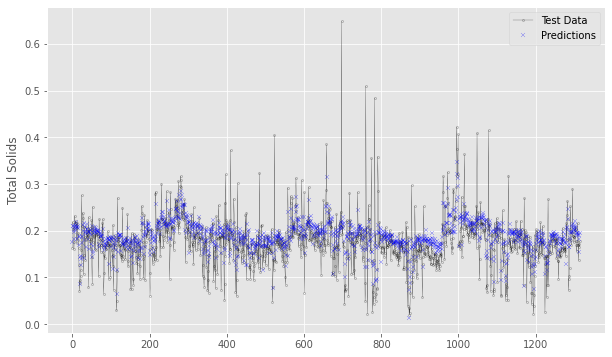

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 2/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0231 - mae: 0.0231 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0259 - val_mae: 0.0259
Epoch 4/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0200 - val_mae: 0.0200
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0193 - val_mae: 0.0193
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0226 - mae: 0.0226 - val_loss: 0.0225 - val_mae: 0.0225
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0213 - val_mae: 0.0213
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

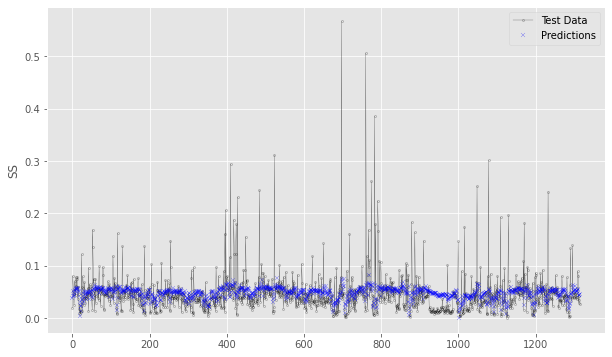

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0171 - mae: 0.0171 - val_loss: 0.0137 - val_mae: 0.0137
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0150 - mae: 0.0150 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0149 - mae: 0.0149 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0151 - val_mae: 0.0151
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0147 - mae: 0.0147 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0143 - mae: 0.0143 - val_loss: 0.0136 - val_mae: 0.0136
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

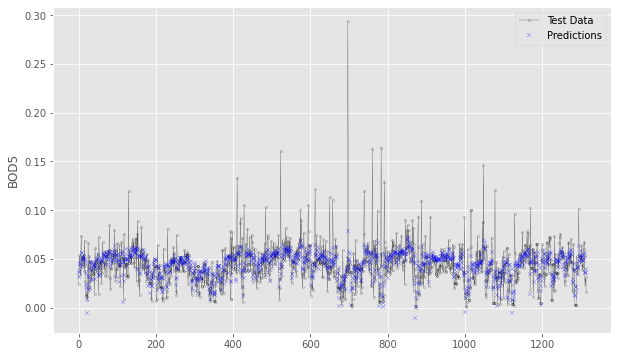

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0808 - mae: 0.0808 - val_loss: 0.0661 - val_mae: 0.0661
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0664 - val_mae: 0.0664
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0573 - mae: 0.0573 - val_loss: 0.0567 - val_mae: 0.0567
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0544 - mae: 0.0544 - val_loss: 0.0578 - val_mae: 0.0578
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0543 - mae: 0.0543 - val_loss: 0.0603 - val_mae: 0.0603
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0543 - mae: 0.0543 - val_loss: 0.0541 - val_mae: 0.0541
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0531 - mae: 0.0531 - val_loss: 0.0550 - val_mae: 0.0550
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

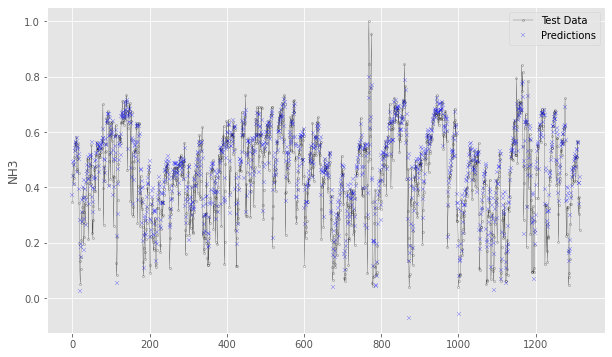

Epoch 1/17
263/263 [==============================] - 2s 8ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0264 - val_mae: 0.0264
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0246 - val_mae: 0.0246
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0240 - val_mae: 0.0240
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0237 - val_mae: 0.0237
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0252 - val_mae: 0.0252
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0235 - val_mae: 0.0235
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0246 - val_mae: 0.0246
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

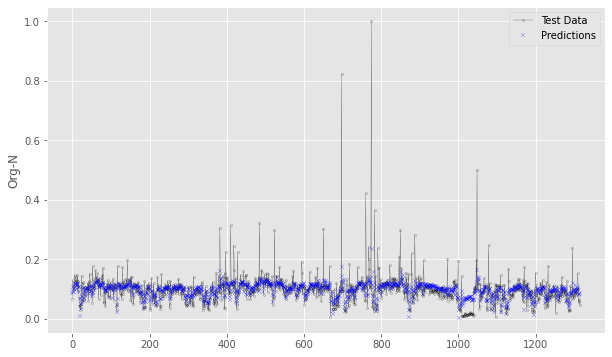

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0357 - val_mae: 0.0357
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0236 - val_mae: 0.0236
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0286 - val_mae: 0.0286
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0255 - val_mae: 0.0255
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0234 - val_mae: 0.0234
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0223 - val_mae: 0.0223
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0232 - mae: 0.0232 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

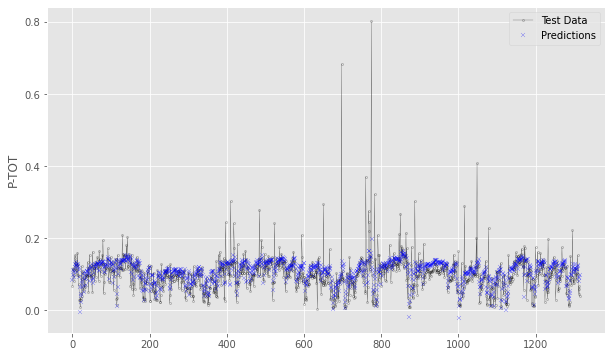

Epoch 1/17
263/263 [==============================] - 2s 8ms/step - loss: 0.0743 - mae: 0.0743 - val_loss: 0.0484 - val_mae: 0.0484
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0443 - mae: 0.0443 - val_loss: 0.0536 - val_mae: 0.0536
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0403 - val_mae: 0.0403
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0332 - mae: 0.0332 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0288 - val_mae: 0.0288
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0303 - val_mae: 0.0303
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0282 - val_mae: 0.0282
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

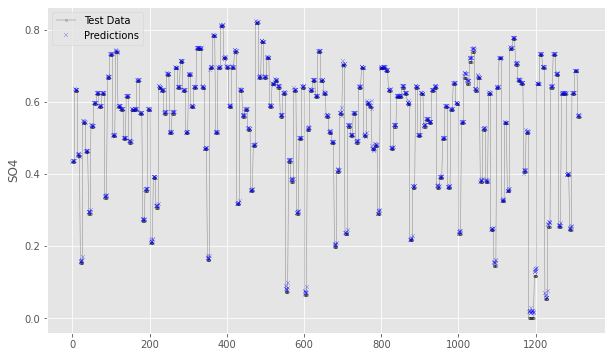

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0304 - mae: 0.0304 - val_loss: 0.0273 - val_mae: 0.0273
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0261 - val_mae: 0.0261
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0295 - val_mae: 0.0295
Epoch 5/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0258 - mae: 0.0258 - val_loss: 0.0256 - val_mae: 0.0256
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0279 - val_mae: 0.0279
Epoch 7/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0256 - mae: 0.0256 - val_loss: 0.0263 - val_mae: 0.0263
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

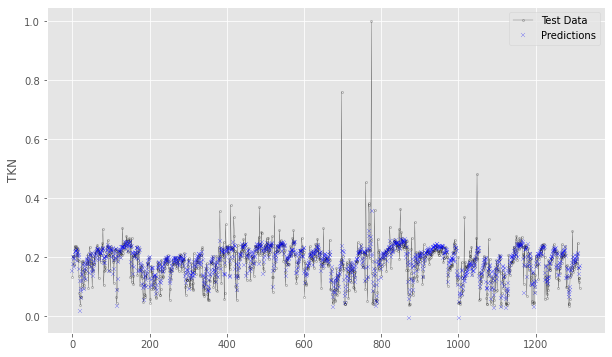

Epoch 1/17
263/263 [==============================] - 2s 9ms/step - loss: 0.0189 - mae: 0.0189 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 2/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0209 - val_mae: 0.0209
Epoch 3/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 4/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0168 - mae: 0.0168 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 5/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 6/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0184 - val_mae: 0.0184
Epoch 7/17
263/263 [==============================] - 2s 6ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 8/17
263/263 [==============================] - 2s 6ms/step - loss: 0.

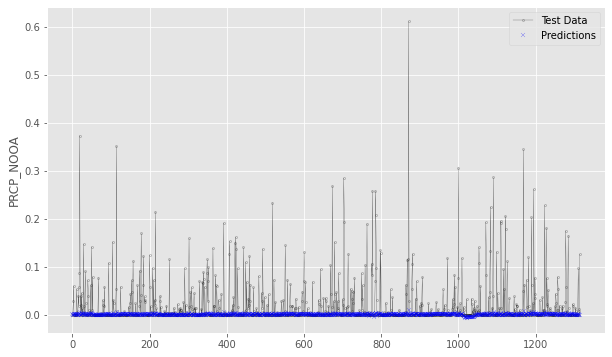

In [8]:
targetList = ["Total Solids",	"SS", 	"BOD5",	"NH3",	"Org-N",	"P-TOT",	"SO4",	"TKN",	"PRCP_NOOA"]
#targetList = ["Total Solids"]
for name in targetList:
    targetDF = series_normalized[name].to_frame()
    #print(X_test)
    size = int(len(X) * 0.8) #split the data into training set (80%) and validation set
    train = X[0:size]
    train_target = targetDF[0:size]
    test = X[size:len(X)]
    test_target = targetDF[size:len(X)]

    X_train = train.values.reshape(-1, lag, num_features).astype('float32')
    y_train = train_target.values.astype('float32')

    X_test = test.values.reshape(-1, lag, num_features).astype('float32')
    y_test = test_target.values.astype('float32')
    
    hidden = 64
    batch_size = 20
    epochs = 17

    #we'll import the Sequential model type from Keras. 
    #This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN and RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden), input_shape=(lag, num_features)))
    model.add(Dense(1))

    model.compile(optimizer='adam',
                loss='mae',
                metrics=['mae'])
 

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test,y_test))

    y_predict = model.predict(X_test)
    plt.style.use("ggplot")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, color='black', linewidth=.2, marker='o', markersize=2,
                markeredgecolor='black', markeredgewidth=0.2, fillstyle='none')
    plt.plot(y_predict, color='blue', linewidth=4, linestyle=' ', marker='x', markersize=4,
                markeredgecolor='blue', markeredgewidth=.2, fillstyle='none')
    plt.legend(('Test Data', 'Predictions'))
    #plt.savefig(name+".png", dpi = 600)
    plt.ylabel(name)

    plt.show()

===========================================================